## svmの制約式
マージン最大化を最小化問題に帰着すると、1/2 ||w||^2の最小化問題になる。<br>
しかし、線形分離可能であるという条件があるので、<br>
正解ラベルy　＊　予測ラベルy(x) > 0(同符号)<br>
が制約条件になる。

線形分離不可能な場合、高次元の空間に射影してその空間で線形分離し、その境界を元の空間に持ち帰る。というアプローチが考えられる。<br>
１次元で線形分離不可能だから、二次元空間に変換して分離する、とか<br>
しかし、高次元の空間での内積(距離の近さを計算)を取る必要があり、計算コストが膨大になる。<br>

そこで**カーネルトリック**を使う。
高次元空間における距離的な物を定義したカーネルKに元の空間の形でデータを入れることで高次元空間での距離を得たのと同等とすること。<br>
本来ならphi(x1)*phi(x2)としなくてはならないところを、K(x1,x2)=(-gamma||x1-x2||)のようにする。<br>
低次元の計算で同等のことが行える。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# iris_dataのよみこみ
from sklearn.datasets import load_iris
iris=load_iris()

In [3]:
X_1 = iris.data[:100,[2,3]]
y_1 = iris.target[:100]

In [4]:
# データの標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_1)
X_1_std = scaler.transform(X_1)

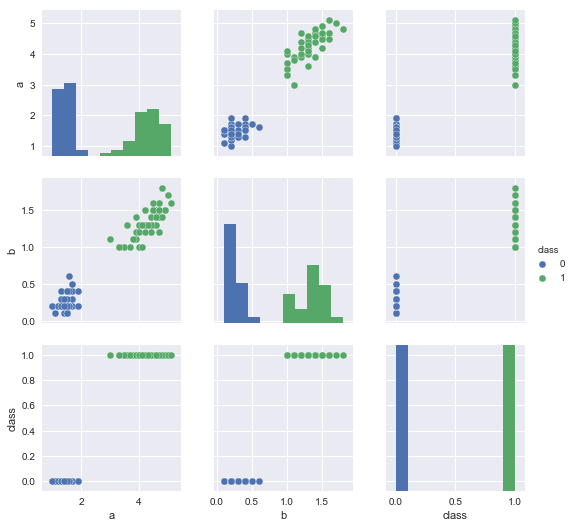

In [34]:
X_df=pd.DataFrame(X_1,columns=['a','b'])
y_df=pd.DataFrame(y_1,columns=['class'])
df=pd.concat((X_df,y_df),axis=1)
import seaborn as sns
sns.pairplot(df,hue='class')
plt.show()

In [37]:
from sklearn.cross_validation import train_test_split
X_1_train,X_1_test,y_train,y_test=train_test_split(X_1_std,y_1,test_size=0.3,random_state=42)

In [56]:
from sklearn.svm import SVC
classifier=SVC(kernel='linear') #defaultだとカーネルはrbf
classifier.fit(X_1_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [42]:
# ２次元データの決定曲線をプロットする関数
def plot_decision_regions(X, y, classifier, resolution=0.02):
    from matplotlib.colors import ListedColormap
    markers = ("s", "x", "o", "^", "v")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min()-1 , X[:, 0].max() +1
    x2_min, x2_max = X[:, 1].min()-1 , X[:, 1].max() +1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx),marker=markers[idx], label=cl)
    plt.show()

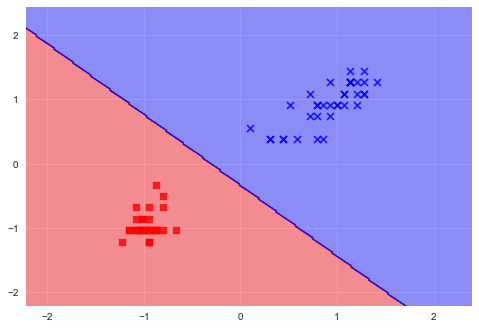

In [43]:
plot_decision_regions(X_1_train,y_train,classifier)

In [45]:
#testデータでの精度を確認
classifier.score(X_1_test,y_test)

1.0

線形分離不可能な場合に、**ソフトマージン**を採用。誤識別を少しだけ認める。<br>
無理にハードマージンを最大化しようとするよりも精度が良くなることが多い。ノイズにフィッティングしようとしてしまうので。

In [49]:
# irisデータセットの読み込み
# 品種: VersicolourとVirsiniga（線形分離不可能①）
# 変数: petal lengthとpetal width
from sklearn.datasets import load_iris
iris = load_iris()
X_2 = iris.data[50:150,[2,3]]
y_2 = iris.target[50:150]

In [50]:
# データの標準化
from sklearn.preprocessing import StandardScaler
scaler_2 = StandardScaler()
scaler_2.fit(X_2)
X_2_std = scaler.transform(X_2)

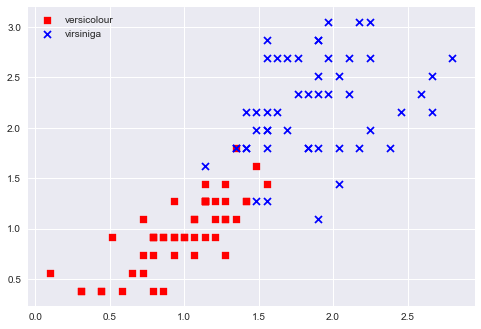

In [52]:
# 散布図を出力
plt.scatter(X_2_std[:50, [0]], X_2_std[:50, [1]], color='red', marker='s',label='versicolour') 
plt.scatter(X_2_std[50:100, [0]], X_2_std[50:100, [1]], color='blue', marker='x',label='virsiniga')
plt.legend(loc='upper left')
plt.show()

In [59]:
# ホールド・アウト法による分割
from sklearn.model_selection import train_test_split
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2_std, y_2, test_size=0.3, random_state=0)

In [60]:
classifier2=SVC(kernel='linear')
classifier2.fit(X_2_train,y_2_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [61]:
classifier2.score(X_2_test,y_2_test)

0.96666666666666667

## カーネル法を使っていこう

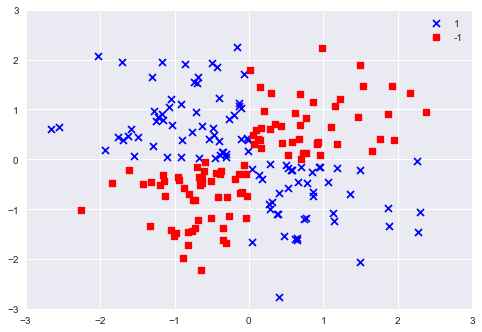

In [62]:
# XORのデータの作成
np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

# データのプロット
plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], c='b', marker='x', label='1')
plt.scatter(X_xor[y_xor == -1, 0], X_xor[y_xor == -1, 1], c='r', marker='s', label='-1')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best') # 右上に凡例を出力
plt.show()

In [63]:
from sklearn.model_selection import train_test_split
X_xor_train, X_xor_test, y_xor_train, y_xor_test = train_test_split(X_xor, y_xor, test_size=0.3, random_state=0)

In [64]:
kernel_svc=SVC(kernel='rbf',C=1.0)
kernel_svc.fit(X_xor_train,y_xor_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [65]:
kernel_svc.score(X_xor_test,y_xor_test)

0.96666666666666667

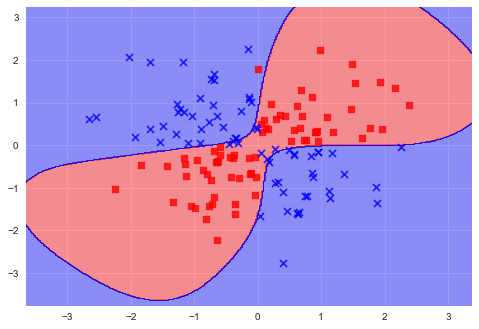

In [66]:
plot_decision_regions(X_xor_train,y_xor_train,kernel_svc)

In [67]:
classifier2.fit(X_xor_train,y_xor_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [69]:
classifier2.score(X_xor_test,y_xor_test)

0.6166666666666667

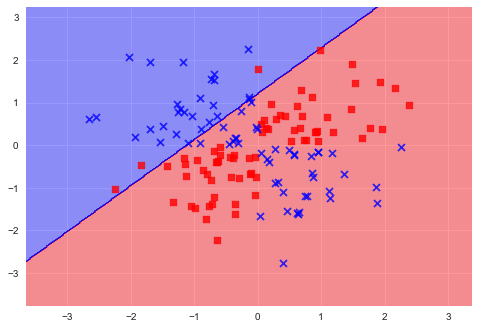

In [68]:
plot_decision_regions(X_xor_train,y_xor_train,classifier2)